In [1]:
import pandas as pd
df = pd.read_csv('final_imputed_with_sofa_firsticu.csv')

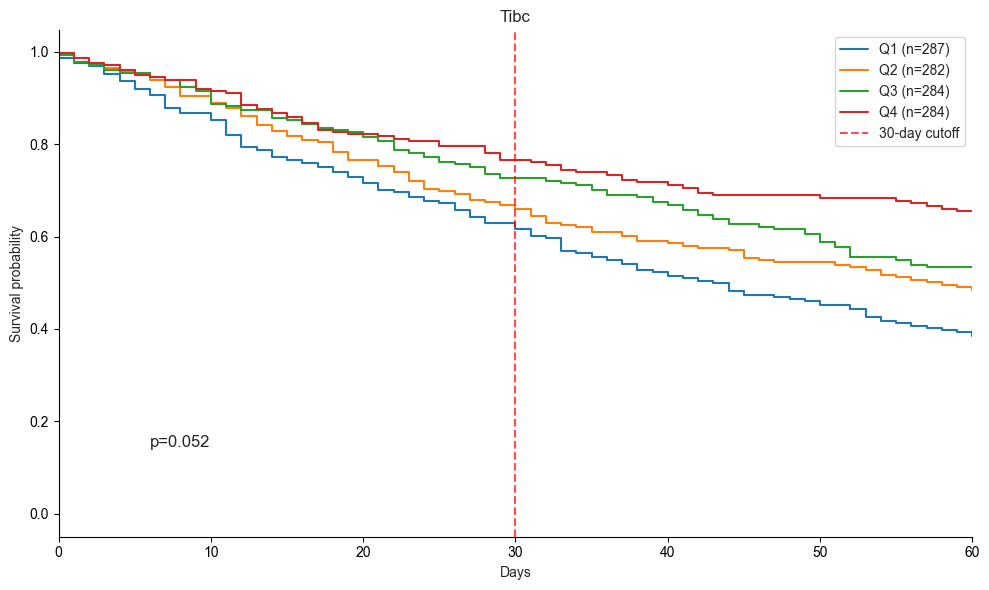

Log-rank检验结果:
统计量: 44.0912
P值: 0.000000
显著性: 显著 (p < 0.05)


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          44.09 <0.005     29.37

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.statistics import logrank_test, multivariate_logrank_test
def plot_km_by_group(df, group_col='tibc_quantile_group', time_col='survival_time', event_col='outcome'):
    """按分组绘制Kaplan-Meier曲线，并用log-rank检验计算p值"""
    # 在函数内部设置样式，确保生效
    sns.set_style("ticks", {
        "axes.grid": False,          # 去除网格
        "axes.edgecolor": "black",   # 边框颜色
        "xtick.color": "black",      # x轴刻度颜色
        "ytick.color": "black"       # y轴刻度颜色
    })
    
    # 确保列存在
    if group_col not in df.columns or time_col not in df.columns or event_col not in df.columns:
        raise ValueError("缺少必要列，请确认 group_col/time_col/event_col 在 df 中存在")

    # 移除缺失值
    df_clean = df.dropna(subset=[group_col, time_col, event_col])
    groups = sorted(df_clean[group_col].unique())
    
    if len(groups) < 2:
        raise ValueError("分组少于2，无法绘制对比曲线或进行log-rank检验")

    # 方法1：使用multivariate_logrank_test（推荐用于多组比较）
    # 准备数据
    event_times = df_clean[time_col].values
    event_observed = df_clean[event_col].values
    group_labels = df_clean[group_col].values
    
    # 进行log-rank检验
    if len(groups) == 2:
        # 两组比较
        mask_A = df_clean[group_col] == groups[0]
        mask_B = df_clean[group_col] == groups[1]
        
        result = logrank_test(
            df_clean.loc[mask_A, time_col], 
            df_clean.loc[mask_B, time_col],
            df_clean.loc[mask_A, event_col], 
            df_clean.loc[mask_B, event_col]
        )
    else:
        # 多组比较 - 使用multivariate_logrank_test
        result = multivariate_logrank_test(
            event_durations=df_clean[time_col],
            groups=df_clean[group_col],
            event_observed=df_clean[event_col]
        )
    
    p_value = result.p_value
    
    # 根据p值决定显示格式
    if p_value < 0.001:
        p_text = 'p < 0.001'
    else:
        p_text = f'p = {p_value:.3f}'
    
    # 绘制Kaplan-Meier曲线
    plt.figure(figsize=(10, 6))
    kmf = KaplanMeierFitter()
    
    # 定义颜色
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for i, g in enumerate(groups):
        mask = df_clean[group_col] == g
        if mask.sum() == 0:
            continue
        
        # 使用模运算确保颜色不越界
        color = colors[i % len(colors)]
        
        kmf.fit(durations=df_clean.loc[mask, time_col],
                event_observed=df_clean.loc[mask, event_col],
                label=f'Q{g} (n={mask.sum()})')
        kmf.plot_survival_function(ci_show=False, color=color)
    
    plt.title(f'{group_col.split("_")[0].capitalize()}')
    plt.xlabel('Days')
    plt.ylabel('Survival probability')
    plt.axvline(x=30, color='red', linestyle='--', alpha=0.7, label='30-day cutoff')
    plt.grid(False)
    plt.legend()
    
    # 在图中添加p值
    plt.text(0.10, 0.20, p_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # 去除上方和右方的边框
    sns.despine(top=True, right=True)
    
    plt.xlim(0, 60)
    plt.tight_layout()
    plt.show()
    
    # 打印详细的log-rank检验结果
    print(f"Log-rank检验结果:")
    print(f"统计量: {result.test_statistic:.4f}")
    print(f"P值: {p_value:.6f}")
    print(f"显著性: {'显著 (p < 0.05)' if p_value < 0.05 else '不显著'}")
    
    return result  # 返回检验结果对象，便于进一步分析

# 使用函数
plot_km_by_group(df)
        # 推荐直接传入原始 df


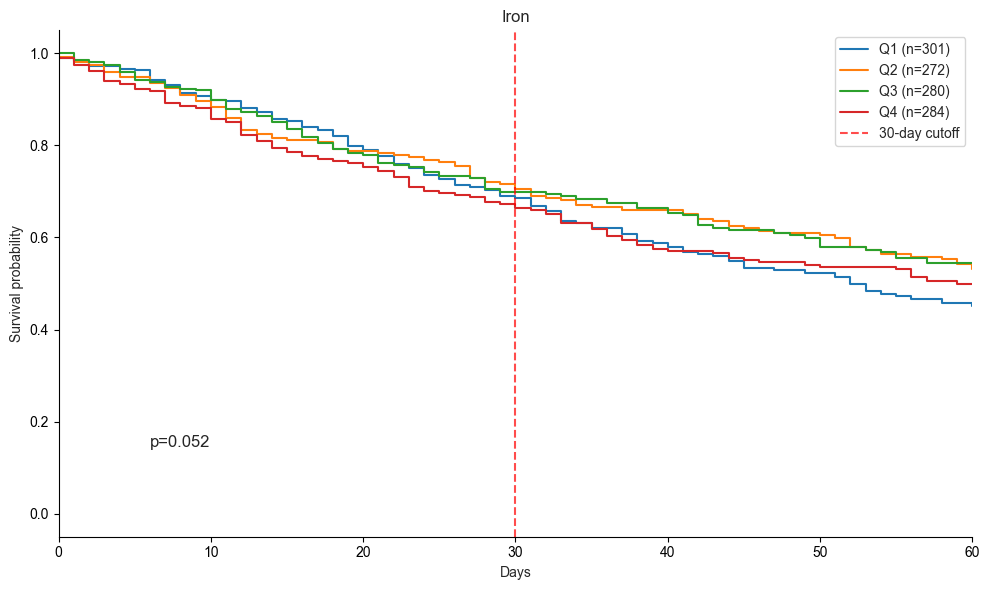

Log-rank检验结果:
统计量: 9.5915
P值: 0.022377
显著性: 显著 (p < 0.05)


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           9.59 0.02      5.48

In [16]:
plot_km_by_group(df, group_col='iron_quantile_group')